<a href="https://colab.research.google.com/github/anand-bidwalkar/SIT796-Reinforcement-Learning/blob/master/Task-4.1D/SIT_796_Task_4_1D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import sys
from contextlib import closing

import numpy as np
from io import StringIO

from gym import utils
from gym.envs.toy_text import discrete

In [4]:
LEFT = 0
DOWN = 1
RIGHT = 2
UP = 3

MAPS = {
    "4x4": [
        "SFFF",
        "FHFH",
        "FFFH",
        "HFFG"
    ],
    "8x8": [
        "SFFFFFFF",
        "FFFFFFFF",
        "FFFHFFFF",
        "FFFFFHFF",
        "FFFHFFFF",
        "FHHFFFHF",
        "FHFFHFHF",
        "FFFHFFFG"
    ],
}


def generate_random_map(size=8, p=0.8):
    valid = False

    # DFS to check that it's a valid path.
    def is_valid(res):
        frontier, discovered = [], set()
        frontier.append((0, 0))
        while frontier:
            r, c = frontier.pop()
            if not (r, c) in discovered:
                discovered.add((r, c))
                directions = [(1, 0), (0, 1), (-1, 0), (0, -1)]
                for x, y in directions:
                    r_new = r + x
                    c_new = c + y
                    if r_new < 0 or r_new >= size or c_new < 0 or c_new >= size:
                        continue
                    if res[r_new][c_new] == 'G':
                        return True
                    if (res[r_new][c_new] != 'H'):
                        frontier.append((r_new, c_new))
        return False

    while not valid:
        p = min(1, p)
        res = np.random.choice(['F', 'H'], (size, size), p=[p, 1-p])
        res[0][0] = 'S'
        res[-1][-1] = 'G'
        valid = is_valid(res)
    return ["".join(x) for x in res]


class FrozenLakeEnv(discrete.DiscreteEnv):

    metadata = {'render.modes': ['human', 'ansi']}

    def __init__(self, desc=None, map_name="4x4", is_slippery=True):
        if desc is None and map_name is None:
            desc = generate_random_map()
        elif desc is None:
            desc = MAPS[map_name]
        self.desc = desc = np.asarray(desc, dtype='c')
        self.nrow, self.ncol = nrow, ncol = desc.shape
        self.reward_range = (0, 1)

        nA = 4
        nS = nrow * ncol

        isd = np.array(desc == b'S').astype('float64').ravel()
        isd /= isd.sum()

        P = {s: {a: [] for a in range(nA)} for s in range(nS)}

        def to_s(row, col):
            return row*ncol + col

        def inc(row, col, a):
            if a == LEFT:
                col = max(col - 1, 0)
            elif a == DOWN:
                row = min(row + 1, nrow - 1)
            elif a == RIGHT:
                col = min(col + 1, ncol - 1)
            elif a == UP:
                row = max(row - 1, 0)
            return (row, col)

        def update_probability_matrix(row, col, action):
            newrow, newcol = inc(row, col, action)
            newstate = to_s(newrow, newcol)
            newletter = desc[newrow, newcol]
            done = bytes(newletter) in b'GH'
            reward = float(newletter == b'G')
            return newstate, reward, done

        for row in range(nrow):
            for col in range(ncol):
                s = to_s(row, col)
                for a in range(4):
                    li = P[s][a]
                    letter = desc[row, col]
                    if letter in b'GH':
                        li.append((1.0, s, 0, True))
                    else:
                        if is_slippery:
                            for b in [(a - 1) % 4, a, (a + 1) % 4]:
                                li.append((
                                    1. / 3.,
                                    *update_probability_matrix(row, col, b)
                                ))
                        else:
                            li.append((
                                1., *update_probability_matrix(row, col, a)
                            ))

        super(FrozenLakeEnv, self).__init__(nS, nA, P, isd)

    def render(self, mode='human'):
        outfile = StringIO() if mode == 'ansi' else sys.stdout

        row, col = self.s // self.ncol, self.s % self.ncol
        desc = self.desc.tolist()
        desc = [[c.decode('utf-8') for c in line] for line in desc]
        desc[row][col] = utils.colorize(desc[row][col], "red", highlight=True)
        if self.lastaction is not None:
            outfile.write("  ({})\n".format(
                ["Left", "Down", "Right", "Up"][self.lastaction]))
        else:
            outfile.write("\n")
        outfile.write("\n".join(''.join(line) for line in desc)+"\n")

In [5]:
def play_episodes(enviorment, n_episodes, policy, random = False):
    
    total_reward = 0
    episode_rewards = []
    
    for episode in range(n_episodes):
        
        terminated = False        
        state = enviorment.reset()
        
        while not terminated:
            
            # check if the random flag is not true then follow the given policy other wise take random action
            if random:
                action = enviorment.action_space.sample()
            else:
                action = policy[state]

            # take the next step
            next_state, reward,  terminated, info = enviorment.step(action)
            
            # accumalate total reward
            total_reward += reward
            
            # change the state
            state = next_state

            episode_rewards.append((episode, total_reward))
                
    average_reward = total_reward / n_episodes
    
    return total_reward, average_reward, episode_rewards


In [6]:
import numpy as np
import gym
env = FrozenLakeEnv()

Random Policy Iteration

In [7]:
n_episode = 1000
total_reward, avg_reward, episode_rewards = play_episodes(env, n_episode, [], random = True)

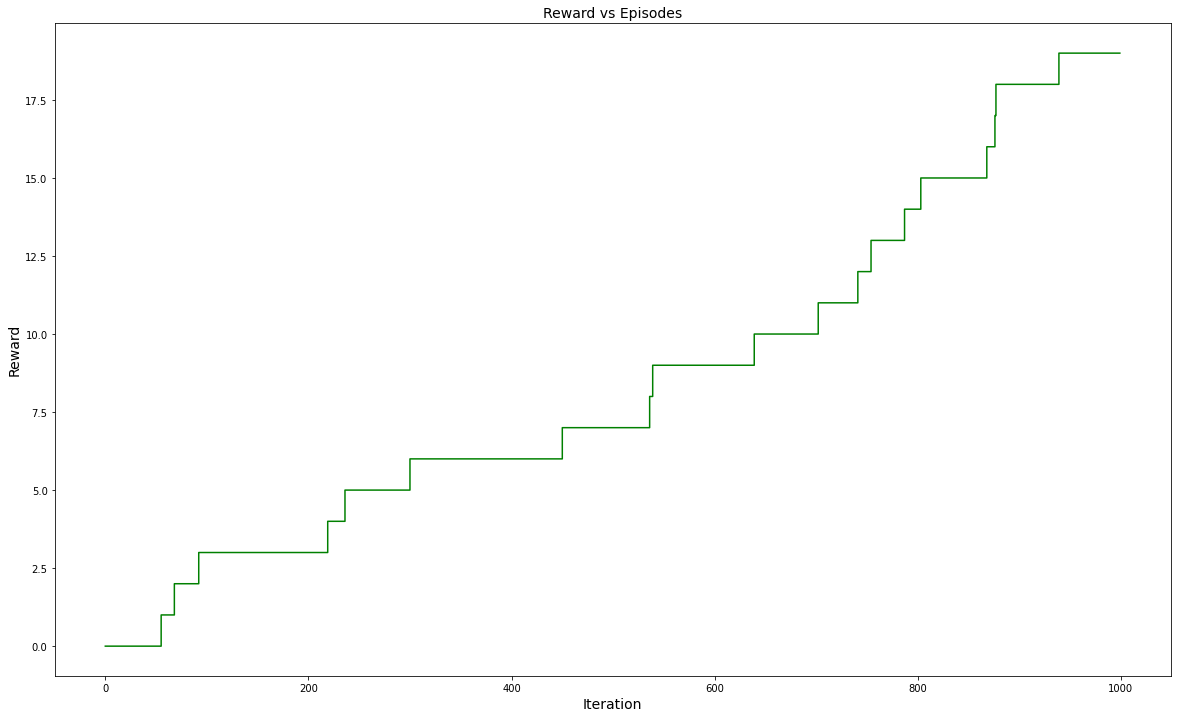

In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 12))
plt.plot([x for x, y in episode_rewards], [y for x, y in episode_rewards],color='green')
plt.title('Reward vs Episodes', fontsize=14)
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('Reward', fontsize=14)
plt.grid(False)
plt.show()

Optimal Policy Iteration and Evaluation

In [9]:
def policy_eval(env, policy, V, discount_factor):

    policy_value = np.zeros(env.nS)
    for state, action in enumerate(policy):
        for probablity, next_state, reward, info in env.P[state][action]:
            policy_value[state] += probablity * (reward + (discount_factor * V[next_state]))
            
    return policy_value

In [10]:
def one_step_lookahead(env, state, V , discount_factor = 0.90):    
    action_values = np.zeros(env.nA)
    
    for action in range(env.nA):
        for probablity, next_state, reward, info in env.P[state][action]:
            action_values[action] += probablity * (reward + (discount_factor * V[next_state]))
            
    return action_values

In [11]:
def update_policy(env, policy, V, discount_factor):    
    
    for state in range(env.nS):
        action_values = one_step_lookahead(env, state, V, discount_factor)        
        policy[state] =  np.argmax(action_values)
        
    return policy

In [12]:
def policy_iteration(env, discount_factor = 0.90, max_iteration = 1000):

    V = np.zeros(env.nS)    
    policy = np.random.randint(0, 4, env.nS)
    policy_prev = np.copy(policy)
    
    for i in range(max_iteration):
        
        V = policy_eval(env, policy, V, discount_factor)        
        policy = update_policy(env, policy, V, discount_factor)
        
        if i % 10 == 0:
            if (np.all(np.equal(policy, policy_prev))):
                print('policy converged at iteration %d' %(i+1))
                break
            policy_prev = np.copy(policy)
                        
    return V, policy

In [13]:
opt_V2, opt_policy2 = policy_iteration(env, discount_factor = 0.90, max_iteration = 10000)
print('Optimal Value function: ')
print(opt_V2.reshape((4, 4)))
print('Final Policy: ')
print(opt_policy2)

policy converged at iteration 31
Optimal Value function: 
[[0.0651776  0.05828125 0.07212566 0.05331999]
 [0.08846727 0.         0.11096941 0.        ]
 [0.14267761 0.24562088 0.29829636 0.        ]
 [0.         0.37856825 0.63829882 0.        ]]
Final Policy: 
[0 3 0 3 0 0 0 0 3 1 0 0 0 2 1 0]


In [14]:
n_episode = 1000
total_reward, avg_reward, episode_rewards = play_episodes(env, n_episode, opt_policy2, random = False)

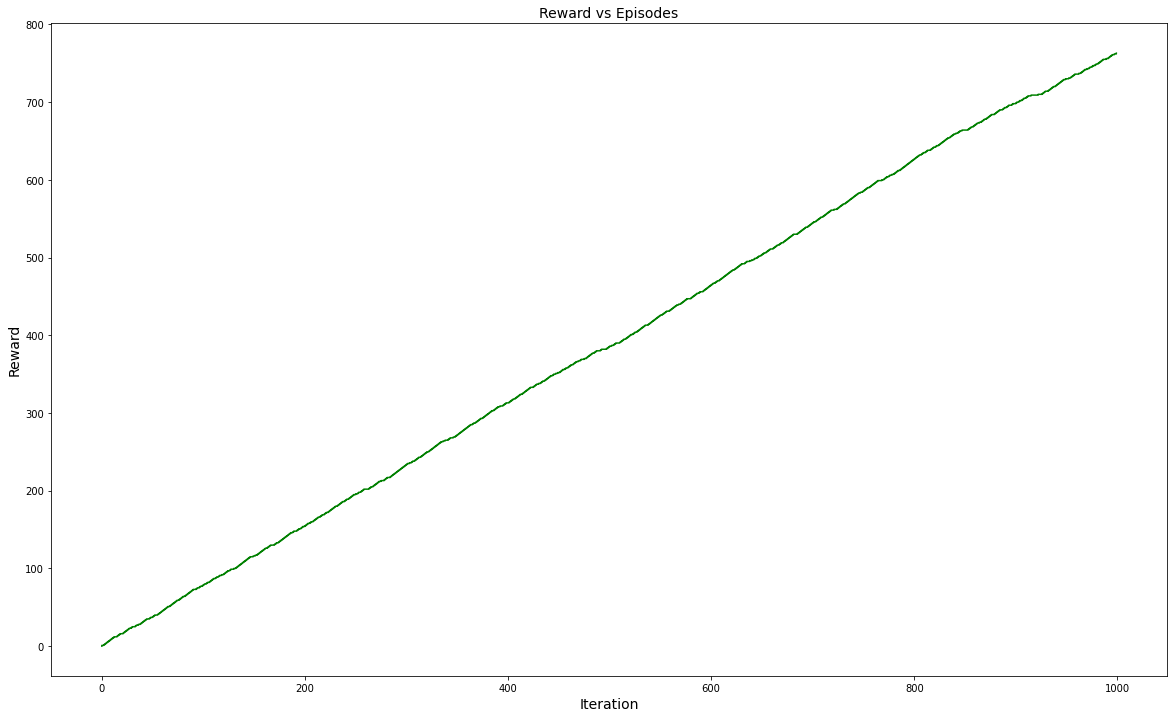

In [15]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 12))
plt.plot([x for x, y in episode_rewards], [y for x, y in episode_rewards],color='green')
plt.title('Reward vs Episodes', fontsize=14)
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('Reward', fontsize=14)
plt.grid(False)
plt.show()

Value Iteration

In [16]:
def value_iteration(env, discount_factor = 0.999, max_iteration = 1000):

    V = np.zeros(env.nS)
    
    for i in range(max_iteration):
        prev_v = np.copy(V) 
        for state in range(env.nS):
            
            action_values = one_step_lookahead(env, state, prev_v, discount_factor)
            best_action_value = np.max(action_values)
                        
            V[state] =  best_action_value
                    
        if i % 10 == 0:            
            if (np.all(np.isclose(V, prev_v))):
                print('Value converged at iteration %d' %(i+1))
                break    
    
    optimal_policy = np.zeros(env.nS, dtype = 'int8')
    optimal_policy = update_policy(env, optimal_policy, V, discount_factor)
    
    return V, optimal_policy

In [17]:
opt_V, opt_Policy = value_iteration(env, max_iteration = 1000)
print('Optimal Value function: ')
print(opt_V.reshape((4, 4)))
print('Final Policy: ')
print(opt_Policy)

Value converged at iteration 341
Optimal Value function: 
[[0.78538826 0.77836049 0.77368481 0.7713498 ]
 [0.78775777 0.         0.50562724 0.        ]
 [0.79250312 0.79963699 0.74472318 0.        ]
 [0.         0.86409247 0.93114742 0.        ]]
Final Policy: 
[0 3 3 3 0 0 0 0 3 1 0 0 0 2 1 0]


In [18]:
n_episode = 1000
total_reward, avg_reward, episode_rewards = play_episodes(env, n_episode, opt_Policy, random = False)

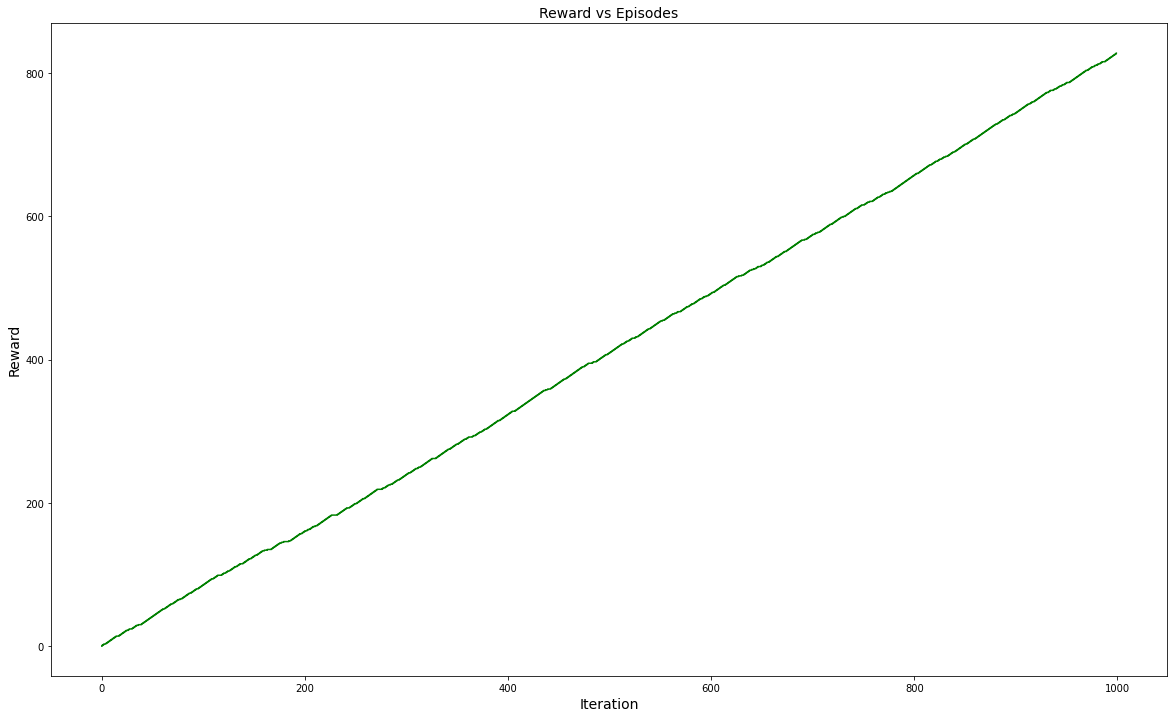

In [19]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 12))
plt.plot([x for x, y in episode_rewards], [y for x, y in episode_rewards],color='green')
plt.title('Reward vs Episodes', fontsize=14)
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('Reward', fontsize=14)
plt.grid(False)
plt.show()